# Sequence Modeling — RNN, LSTM (and GRU) Visual Guide

This notebook demonstrates **sequence models** for **time‑series forecasting** with Keras:
- Synthetic **univariate series**: trend + seasonality + noise
- Windowing the series into `(sequence_length → next value)` pairs
- Models: **SimpleRNN**, **LSTM**, and **GRU**
- **Training curves** (loss) and **forecast plots**
- Hyperparameter sweeps: **sequence length**, **hidden units**, and **dropout**
- Baselines: **Naive (last value)** and **Moving Average**

> If TensorFlow/Keras is not available, cells will politely skip and show an install tip.

TensorFlow version: 2.20.0


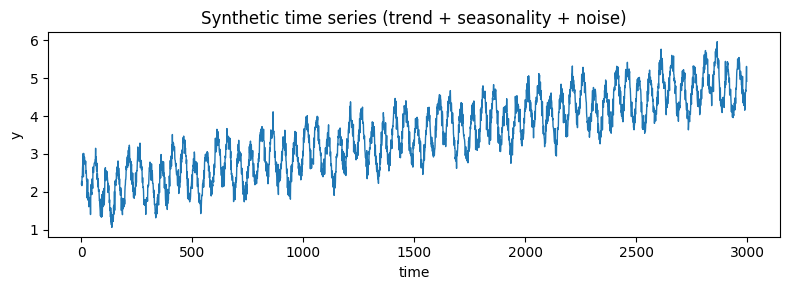

(2000, 500, 500)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Try to import TensorFlow/Keras; if not available, we will skip training with guidance.
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    TF_AVAILABLE = True
    print("TensorFlow version:", tf.__version__)
except Exception as e:
    TF_AVAILABLE = False
    print("TensorFlow/Keras not available. To enable training here, run:")
    print("  pip install tensorflow-cpu  # or tensorflow")
    print("Cells that require TF will be skipped.")

np.random.seed(2027)

# Create synthetic time series: trend + two seasonalities + noise
n = 3000
t = np.arange(n)
trend = 0.001 * t
season1 = 0.6 * np.sin(2*np.pi*t/50)
season2 = 0.3 * np.sin(2*np.pi*t/200 + 0.5)
noise = 0.15 * np.random.randn(n)
y = 2.0 + trend + season1 + season2 + noise

# Train/val/test split (chronological)
n_train = 2000
n_val = 500
y_train = y[:n_train]
y_val   = y[n_train:n_train+n_val]
y_test  = y[n_train+n_val:]

plt.figure(figsize=(8,3))
plt.plot(y, linewidth=1)
plt.title("Synthetic time series (trend + seasonality + noise)")
plt.xlabel("time"); plt.ylabel("y")
plt.tight_layout(); plt.show()

len(y_train), len(y_val), len(y_test)

## Build supervised windows (X → y)

In [2]:
def build_windows(series, seq_len=32, horizon=1):
    X, Y = [], []
    for i in range(len(series) - seq_len - horizon + 1):
        X.append(series[i:i+seq_len])
        Y.append(series[i+seq_len:i+seq_len+horizon])
    X = np.array(X)[:, :, None]  # (N, seq_len, 1)
    Y = np.array(Y)               # (N, horizon)
    return X, Y

# Default windows
SEQ_LEN = 32
H = 1
Xtr, Ytr = build_windows(y_train, seq_len=SEQ_LEN, horizon=H)
Xva, Yva = build_windows(np.concatenate([y_train[-SEQ_LEN:], y_val]), seq_len=SEQ_LEN, horizon=H)  # allow continuity
Xte, Yte = build_windows(np.concatenate([y_train[-SEQ_LEN:], y_val, y_test]), seq_len=SEQ_LEN, horizon=H)

print("Shapes: Xtr", Xtr.shape, "Ytr", Ytr.shape, "| Xva", Xva.shape, "Yva", Yva.shape, "| Xte", Xte.shape, "Yte", Yte.shape)

Shapes: Xtr (1968, 32, 1) Ytr (1968, 1) | Xva (500, 32, 1) Yva (500, 1) | Xte (1000, 32, 1) Yte (1000, 1)


## Baseline forecasters (naive & moving average)

Naive RMSE (test): 0.2126
Moving average RMSE (test): 0.5721


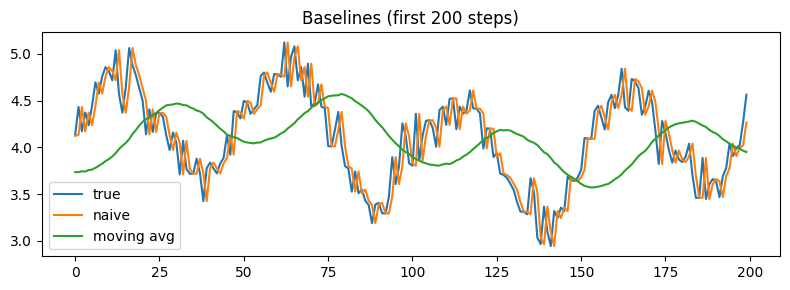

In [3]:
def rmse(a, b): 
    return np.sqrt(np.mean((a-b)**2))

# Align test targets with predictions (one-step ahead)
Yte_true = Yte[:,0]

# Naive: predict last observed value in the window
yhat_naive = Xte[:,-1,0]
rmse_naive = rmse(Yte_true, yhat_naive)
print("Naive RMSE (test):", round(rmse_naive, 4))

# Moving average over window
yhat_ma = Xte.mean(axis=1)[:,0]
rmse_ma = rmse(Yte_true, yhat_ma)
print("Moving average RMSE (test):", round(rmse_ma, 4))

# Quick plot
plt.figure(figsize=(8,3))
plt.plot(Yte_true[:200], label="true")
plt.plot(yhat_naive[:200], label="naive")
plt.plot(yhat_ma[:200], label="moving avg")
plt.title("Baselines (first 200 steps)"); plt.legend(); plt.tight_layout(); plt.show()

## Build RNN / LSTM / GRU models

In [4]:
def build_model(kind="lstm", units=32, dropout=0.0, lr=1e-3, horizon=1):
    if not TF_AVAILABLE:
        return None
    model = keras.Sequential()
    if kind == "rnn":
        model.add(layers.SimpleRNN(units, input_shape=(None,1)))
    elif kind == "gru":
        model.add(layers.GRU(units, input_shape=(None,1), dropout=dropout, recurrent_dropout=0.0))
    else:
        model.add(layers.LSTM(units, input_shape=(None,1), dropout=dropout, recurrent_dropout=0.0))
    model.add(layers.Dense(horizon))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss="mse")
    return model

def train_model(model, Xtr, Ytr, Xva, Yva, epochs=40, batch=64):
    if not TF_AVAILABLE or model is None:
        return None
    es = keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)
    hist = model.fit(Xtr, Ytr, validation_data=(Xva, Yva), epochs=epochs, batch_size=batch, verbose=0, callbacks=[es])
    return hist

## Train a baseline LSTM

/Users/xtra-moon2472/PythonProjects/Git/ust-mail/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


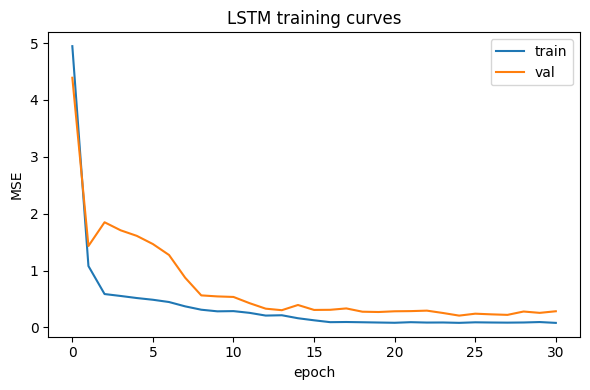

LSTM RMSE (test): 0.5491


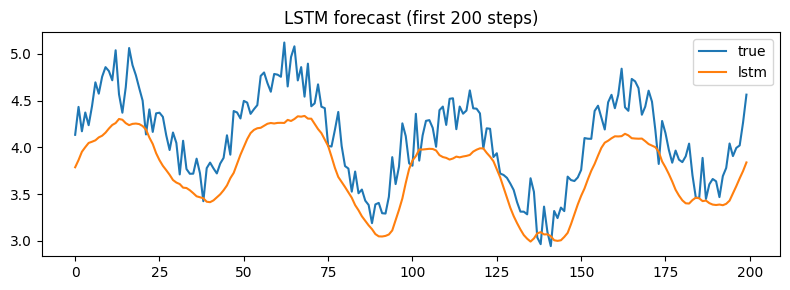

In [5]:
if TF_AVAILABLE:
    lstm = build_model(kind="lstm", units=32, dropout=0.1, lr=1e-3, horizon=H)
    hist_lstm = train_model(lstm, Xtr, Ytr, Xva, Yva, epochs=60, batch=64)
    plt.figure(figsize=(6,4)); plt.plot(hist_lstm.history["loss"], label="train"); plt.plot(hist_lstm.history["val_loss"], label="val")
    plt.xlabel("epoch"); plt.ylabel("MSE"); plt.title("LSTM training curves"); plt.legend(); plt.tight_layout(); plt.show()

    # Forecast on test windows
    yhat_lstm = lstm.predict(Xte, verbose=0)[:,0]
    print("LSTM RMSE (test):", round(np.sqrt(np.mean((Yte_true - yhat_lstm)**2)), 4))

    # Plot a slice
    plt.figure(figsize=(8,3))
    plt.plot(Yte_true[:200], label="true")
    plt.plot(yhat_lstm[:200], label="lstm")
    plt.title("LSTM forecast (first 200 steps)"); plt.legend(); plt.tight_layout(); plt.show()
else:
    print("Skipping LSTM training — TensorFlow not available.")

## Compare SimpleRNN vs LSTM vs GRU

In [6]:
results = []
if TF_AVAILABLE:
    for kind in ["rnn", "lstm", "gru"]:
        m = build_model(kind=kind, units=32, dropout=0.1, lr=1e-3, horizon=H)
        h = train_model(m, Xtr, Ytr, Xva, Yva, epochs=50, batch=64)
        yhat = m.predict(Xte, verbose=0)[:,0]
        r = np.sqrt(np.mean((Yte_true - yhat)**2))
        results.append({"model": kind, "test_rmse": r})
        print(kind, "test RMSE:", round(r, 4))

    df = pd.DataFrame(results)
    print(df)
else:
    print("Skipping comparison — TensorFlow not available.")

rnn test RMSE: 0.3235
lstm test RMSE: 0.5272
gru test RMSE: 0.5125
  model  test_rmse
0   rnn   0.323547
1  lstm   0.527223
2   gru   0.512480


## Sequence length sweep (LSTM units=32)

/Users/xtra-moon2472/PythonProjects/Git/ust-mail/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


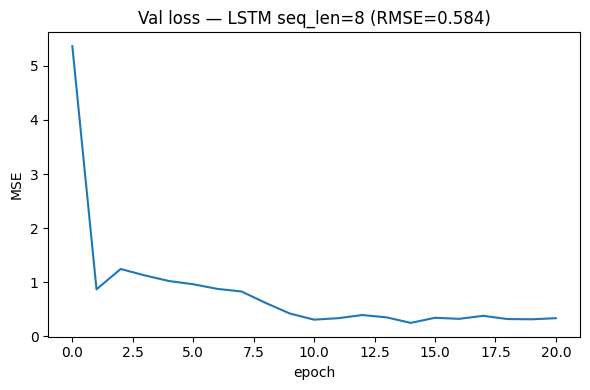

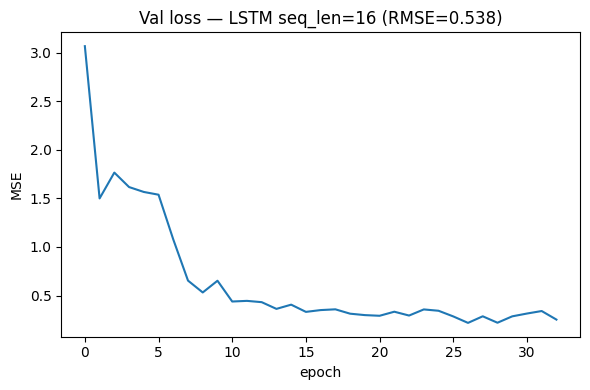

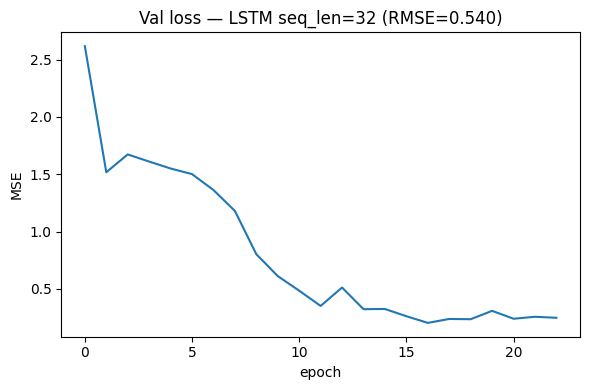

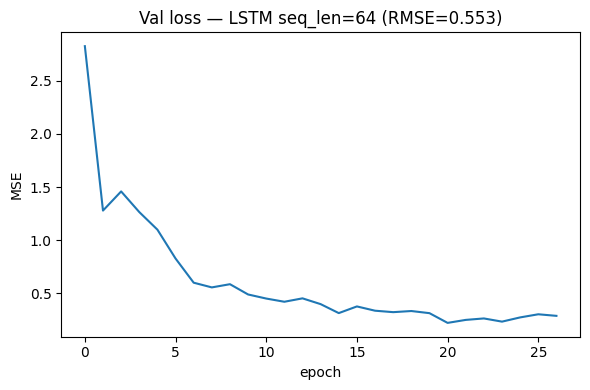

In [7]:
if TF_AVAILABLE:
    for L in [8, 16, 32, 64]:
        XtrL, YtrL = build_windows(y_train, seq_len=L, horizon=H)
        XvaL, YvaL = build_windows(np.concatenate([y_train[-L:], y_val]), seq_len=L, horizon=H)
        XteL, YteL = build_windows(np.concatenate([y_train[-L:], y_val, y_test]), seq_len=L, horizon=H)
        lstmL = build_model(kind="lstm", units=32, dropout=0.1, lr=1e-3, horizon=H)
        h = train_model(lstmL, XtrL, YtrL, XvaL, YvaL, epochs=40, batch=64)
        yhat = lstmL.predict(XteL, verbose=0)[:,0]
        r = np.sqrt(np.mean((YteL[:,0] - yhat)**2))
        plt.figure(figsize=(6,4)); plt.plot(h.history["val_loss"]); plt.title(f"Val loss — LSTM seq_len={L} (RMSE={r:.3f})"); plt.xlabel("epoch"); plt.ylabel("MSE"); plt.tight_layout(); plt.show()
else:
    print("Skipping sweep — TensorFlow not available.")

## Hidden units & dropout sweep (LSTM)

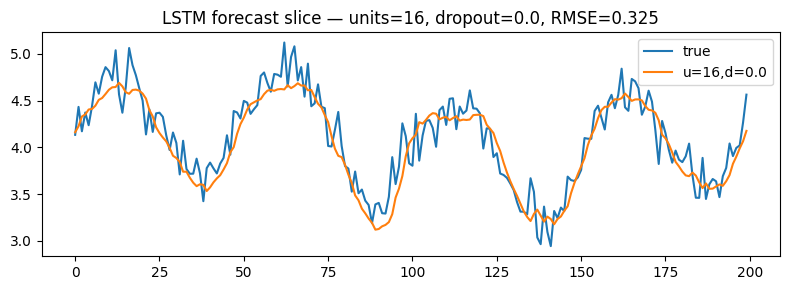

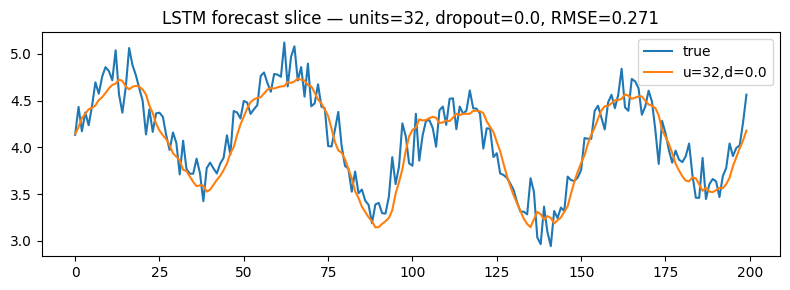

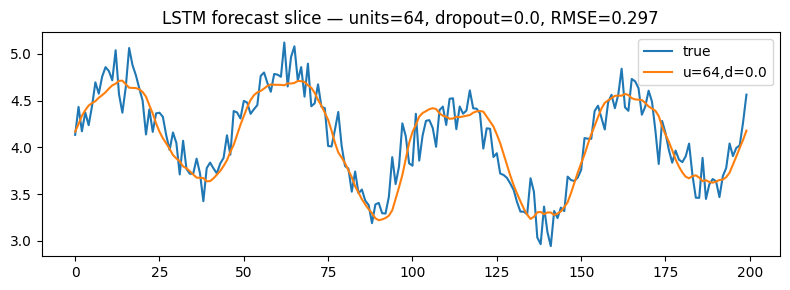

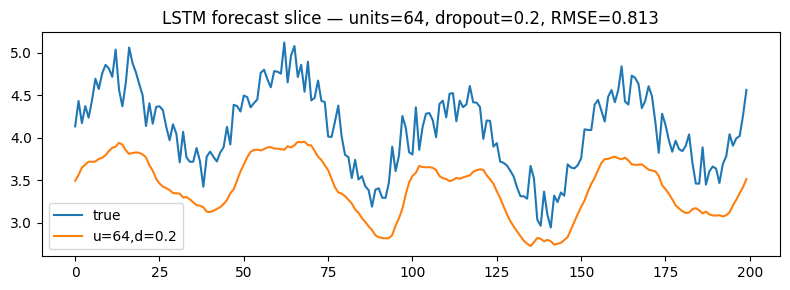

   units  dropout  test_rmse
0     16      0.0   0.325188
1     32      0.0   0.270605
2     64      0.0   0.297324
3     64      0.2   0.812539


In [8]:
if TF_AVAILABLE:
    configs = [(16,0.0),(32,0.0),(64,0.0),(64,0.2)]
    tab = []
    for units, dr in configs:
        m = build_model(kind="lstm", units=units, dropout=dr, lr=1e-3, horizon=H)
        h = train_model(m, Xtr, Ytr, Xva, Yva, epochs=40, batch=64)
        yhat = m.predict(Xte, verbose=0)[:,0]
        r = np.sqrt(np.mean((Yte_true - yhat)**2))
        tab.append({"units":units, "dropout":dr, "test_rmse":r})
        plt.figure(figsize=(8,3)); 
        plt.plot(Yte_true[:200], label="true"); plt.plot(yhat[:200], label=f"u={units},d={dr}")
        plt.title(f"LSTM forecast slice — units={units}, dropout={dr}, RMSE={r:.3f}"); plt.legend(); plt.tight_layout(); plt.show()
    print(pd.DataFrame(tab))
else:
    print("Skipping sweep — TensorFlow not available.")

## Multi-step horizon forecast (H=10)

/Users/xtra-moon2472/PythonProjects/Git/ust-mail/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


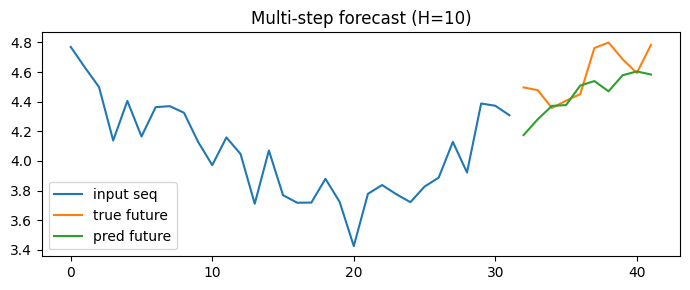

In [9]:
if TF_AVAILABLE:
    H = 10
    XtrH, YtrH = build_windows(y_train, seq_len=SEQ_LEN, horizon=H)
    XvaH, YvaH = build_windows(np.concatenate([y_train[-SEQ_LEN:], y_val]), seq_len=SEQ_LEN, horizon=H)
    XteH, YteH = build_windows(np.concatenate([y_train[-SEQ_LEN:], y_val, y_test]), seq_len=SEQ_LEN, horizon=H)
    mH = build_model(kind="lstm", units=64, dropout=0, lr=1e-3, horizon=H)
    hH = train_model(mH, XtrH, YtrH, XvaH, YvaH, epochs=60, batch=64)
    YhatH = mH.predict(XteH, verbose=0)  # shape: (N, H)

    # Plot the first forecast window's path vs truth
    i = 50
    plt.figure(figsize=(7,3))
    plt.plot(range(SEQ_LEN), XteH[i,:,0], label="input seq")
    plt.plot(range(SEQ_LEN, SEQ_LEN+H), YteH[i], label="true future")
    plt.plot(range(SEQ_LEN, SEQ_LEN+H), YhatH[i], label="pred future")
    plt.title("Multi-step forecast (H=10)")
    plt.legend(); plt.tight_layout(); plt.show()
else:
    print("Skipping multi-step demo — TensorFlow not available.")